# Prepare data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
import numpy as np

In [2]:
## Hyper-parameters
RATIO = 0.8   ## What ratio of total lines used for training (the rest is for validation)
FC_SIZE = 512
LR = 1e-4
L2_REG = 0.01
EPOCH = 5
BATCH_SIZE = 200
KERNEL_SIZE = 5     ## One side (square)
FEATURE_MAP1 = 32   ## First conv layer feature maps
FEATURE_MAP2 = 64  ## Second conv layer feature maps

In [3]:
with open("../data/extended4_train.csv") as f:
    lines = [line for line in f]

In [4]:
lines = [np.array(line.split(","), dtype='float32') for line in lines[1:]]

In [13]:
training_images = []
training_labels = []
validation_images = []
validation_labels = []
for line in lines[:int(len(lines) * RATIO)]:
    one_hot = np.zeros((10), dtype='float32')
    one_hot[int(line[0])] = 1.0
    training_labels.append(one_hot)
    training_images.append(line[1:])
training_set = [training_images, training_labels]
for line in lines[int(len(lines) * RATIO):]:
    one_hot = np.zeros((10), dtype='float32')
    one_hot[int(line[0])] = 1.0
    validation_labels.append(one_hot)
    validation_images.append(line[1:])
validation_set = [validation_images, validation_labels]

In [14]:
## Constants
TRAINING_SIZE = int(len(lines) * RATIO)
VALIDATION_SIZE = len(lines) - TRAINING_SIZE
TRAINING_BATCH = TRAINING_SIZE / BATCH_SIZE
VALIDATION_BATCH = VALIDATION_SIZE / BATCH_SIZE

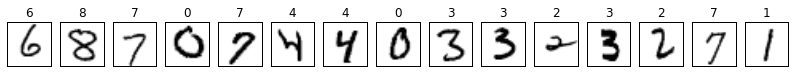

In [29]:
## See random 15 digit with their labels
digits = training_set[:]
x = np.random.randint(0, TRAINING_SIZE - 15)
fig = plt.figure()
for i in xrange(x,x+15):
    plt.subplot(1, 15, i - x + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(digits[1][i].nonzero()[0][0])  ## Label
    plt.imshow(digits[0][i].reshape((28, 28)), cmap=plt.cm.Greys)

In [ ]:
print TRAINING_SIZE, VALIDATION_SIZE

In [ ]:
## Create Batches ##
training_batches = []   ## [[[batch1_images], [batch1_labels]], [[batch2_images], [batch2_labels]], ... ]
for i in range(0, TRAINING_SIZE, BATCH_SIZE):
    training_batch_image = training_set[0][i:i + BATCH_SIZE]
    training_batch_label = training_set[1][i:i + BATCH_SIZE]
    training_batches.append([training_batch_image, training_batch_label])
    
validation_batches = []
for i in range(0, VALIDATION_SIZE, BATCH_SIZE):
    validation_batch_image = validation_set[0][i:i + BATCH_SIZE]
    validation_batch_label = validation_set[1][i:i + BATCH_SIZE]
    validation_batches.append([validation_batch_image, validation_batch_label])

# Preparing network

In [ ]:
import tensorflow as tf
import time

In [ ]:
#def weight_variable(shape):
#  initial = tf.truncated_normal(shape, stddev=0.1)
#  return tf.Variable(initial)
def weight_variable(n_inputs, n_outputs):
    return tf.Variable(xavier_init(n_inputs, n_outputs))

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [ ]:
## Input, output vectors
x = tf.placeholder(tf.float32, [None, 784])  ## Here 'None' means that a dimension can be of any length
y_ = tf.placeholder(tf.float32, [None, 10])  ## Correct answers

In [ ]:
## 1st conv layer
## [Kernel size1, Kernel size2, first layer channel, second layer channel channel]
#W_conv1 = weight_variable([KERNEL_SIZE, KERNEL_SIZE, 1, FEATURE_MAP1])

#b_conv1 = bias_variable([FEATURE_MAP1])
with tf.variable_scope("layer1"):
    W_conv1 = tf.get_variable('W_conv1', shape=(KERNEL_SIZE, KERNEL_SIZE, 1, FEATURE_MAP1), 
                              initializer=tf.contrib.layers.xavier_initializer())
    b_conv1 = tf.get_variable('b_conv1', shape=(FEATURE_MAP1),
                              initializer=tf.contrib.layers.xavier_initializer())
    
# [.., shape1, shape2, channel]
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)    

In [ ]:
## 2nd conv layer
with tf.variable_scope("layer2"):
    W_conv2 = tf.get_variable('W_conv2', shape=(KERNEL_SIZE, KERNEL_SIZE, FEATURE_MAP1, FEATURE_MAP2), 
                              initializer=tf.contrib.layers.xavier_initializer())
    b_conv2 = tf.get_variable('b_conv1', shape=(FEATURE_MAP2),
                              initializer=tf.contrib.layers.xavier_initializer())
#W_conv2 = weight_variable([KERNEL_SIZE, KERNEL_SIZE, FEATURE_MAP1, FEATURE_MAP2])
#b_conv2 = bias_variable([FEATURE_MAP2])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [ ]:
## Fully connected layer

## Image shape halves twice. (28x28) -> (14x14) -> (7x7) by max_pool_2x2
## Conv. layer does not change image size because of padding='SAME'
with tf.variable_scope("layer3"):
    W_fc1 = tf.get_variable('W_fc1', shape=(7 * 7 * FEATURE_MAP2, FC_SIZE), 
                              initializer=tf.contrib.layers.xavier_initializer())
    b_fc1 = tf.get_variable('b_fc1', shape=(FC_SIZE),
                              initializer=tf.contrib.layers.xavier_initializer())
#W_fc1 = weight_variable([7 * 7 * FEATURE_MAP2, FC_SIZE])  
#b_fc1 = bias_variable([FC_SIZE])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * FEATURE_MAP2])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [ ]:
## Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [ ]:
## Softmax output
with tf.variable_scope("layer4"):
    W_fc2 = tf.get_variable('W_fc1', shape=(FC_SIZE, 10), 
                              initializer=tf.contrib.layers.xavier_initializer())
    b_fc2 = tf.get_variable('b_fc2', shape=(10),
                              initializer=tf.contrib.layers.xavier_initializer())
#W_fc2 = weight_variable([FC_SIZE, 10])
#b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(LR).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    ##############
    ## Training ##
    ##############

    #saver.restore(sess, "../model/MLP_tensorflow/MLP_tensorflow.ckpt")
    #print("Model restored.")

    training_accuracy = 0.0
    t0 = time.time()
    for i in xrange(EPOCH * TRAINING_BATCH):
        
        j = i % TRAINING_BATCH
        sess.run(train_step, feed_dict={x: training_batches[j][0], y_: training_batches[j][1], keep_prob: 0.5})
        batch_accuracy = sess.run(accuracy, feed_dict={x: training_batches[j][0], y_: training_batches[j][1], keep_prob: 1.0})
        training_accuracy += batch_accuracy
        
        if (i + 1) / float(TRAINING_BATCH) == (i + 1) / TRAINING_BATCH:
            print "Epoch",  (i + 1) / TRAINING_BATCH, "\n\tTraining accuracy: {0:f}".format(training_accuracy / TRAINING_BATCH)
            training_accuracy = 0.0
            np.random.shuffle(training_batches)
            
            ################
            ## Validating ##
            ################
            
            if RATIO != 1.0:
                validation_accuracy = 0.0
                for k in xrange(VALIDATION_BATCH):
                    batch_accuracy = sess.run(accuracy, feed_dict={x: validation_batches[k][0], y_: validation_batches[k][1], keep_prob: 1.0})
                    validation_accuracy += batch_accuracy

                print "\tValidation accuracy: {0:f}".format(validation_accuracy / VALIDATION_BATCH)
                np.random.shuffle(validation_batches)

        #classification = sess.run(y_conv, feed_dict={x: training_batch_images[j], keep_prob: 1.0})
        #print classification
        #print training_batch_labels[j]

    print "Total time:", time.time() - t0

    #save_path = saver.save(sess, "..model/MLP_tensorflow/MLP_tensorflow.ckpt")
    #print("Model saved in file: %s" %save_path)
